# All-gestures model

In [1]:
import os
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from dataset import Dataset
from model import Model
from evaluator import Evaluator

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the data

In [4]:
SPLIT_THRESHOLD = 0.2
BATCH_SIZE = 32
SEED = 42

In [5]:
tf.random.set_seed(SEED)

In [6]:
data = Dataset(split_threshold=SPLIT_THRESHOLD, batch_size=BATCH_SIZE, path=Path('data/asl_classic/asl_classic'), seed=SEED)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [7]:
images, _ = next(iter(data.train))
assert images.numpy().min() == 0
assert images.numpy().max() == 255
assert images.shape == (32, 256, 256, 3)

## Pre-processing

In [8]:
data.preprocess(resize=True, crop=True)

In [9]:
images, _ = next(iter(data.train))
assert images.numpy().min() == 0
assert images.numpy().max() == 255
assert images.shape == (32, 96, 96, 3)

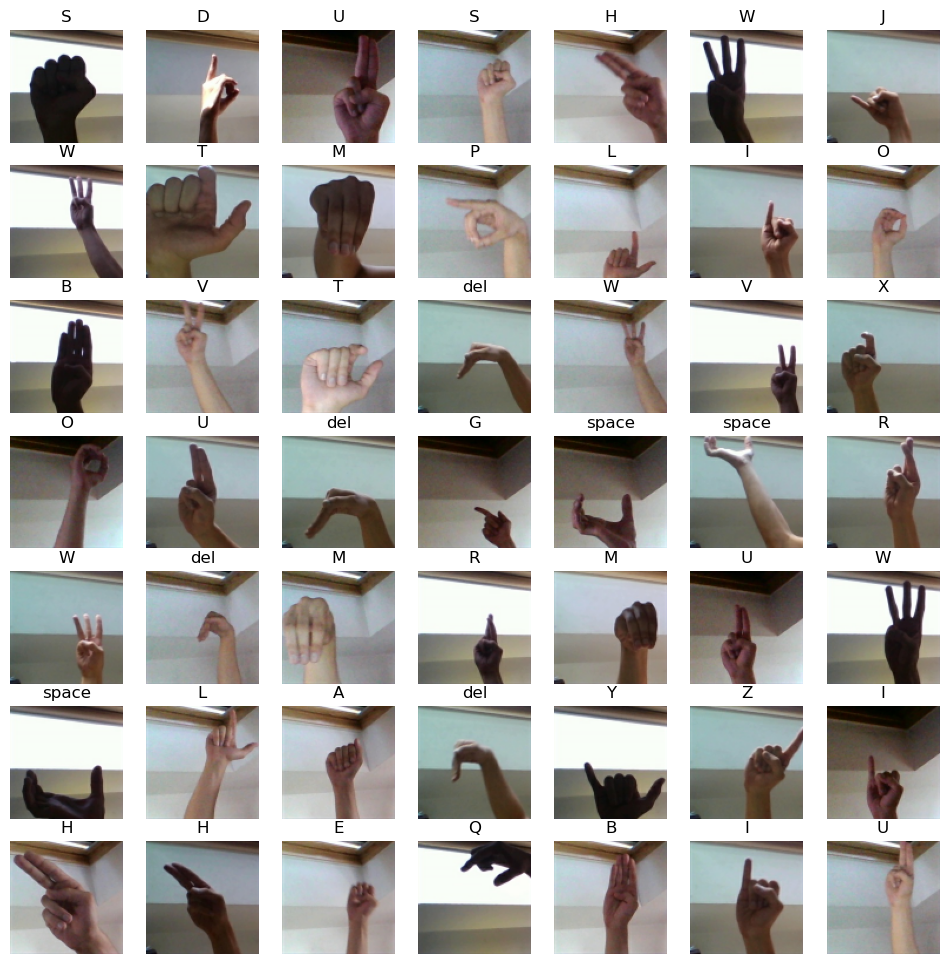

In [10]:
data.visualize_images('train', num_images=7)

In [11]:
data.plot_class_distribution('train', 3000)

In [12]:
data.plot_class_distribution('validation', 3000)

In [13]:
data.rescale()

In [14]:
images, _ = next(iter(data.train))
assert images.numpy().min() == -1
assert images.numpy().max() == 1
assert images.shape == (32, 96, 96, 3)

In [15]:
data.cache()

## Train the model

In [16]:
model = Model(num_classes=len(data.class_labels))

In [17]:
model.plot_model(dpi=800);

In [18]:
model.compile(learning_rate=1e-3)
model.fit(data.train, data.validation, epochs=20, log_dir=Path('logs/fit'))

Epoch 1/20
2175/2175 [==============================] - 60s 26ms/step - loss: 0.2743 - accuracy: 0.9191 - val_loss: 0.0612 - val_accuracy: 0.9794
Epoch 2/20
2175/2175 [==============================] - 19s 9ms/step - loss: 0.0797 - accuracy: 0.9735 - val_loss: 0.0832 - val_accuracy: 0.9755
Epoch 3/20
2175/2175 [==============================] - 19s 9ms/step - loss: 0.0687 - accuracy: 0.9796 - val_loss: 0.0995 - val_accuracy: 0.9730
Epoch 4/20
2175/2175 [==============================] - 19s 9ms/step - loss: 0.0586 - accuracy: 0.9836 - val_loss: 0.0994 - val_accuracy: 0.9737
Epoch 5/20
2175/2175 [==============================] - 19s 9ms/step - loss: 0.0528 - accuracy: 0.9863 - val_loss: 0.0367 - val_accuracy: 0.9897
Epoch 6/20
2175/2175 [==============================] - 19s 9ms/step - loss: 0.0467 - accuracy: 0.9878 - val_loss: 0.0316 - val_accuracy: 0.9920
Epoch 7/20
2175/2175 [==============================] - 19s 9ms/step - loss: 0.0451 - accuracy: 0.9892 - val_loss: 0.0302 - val_a

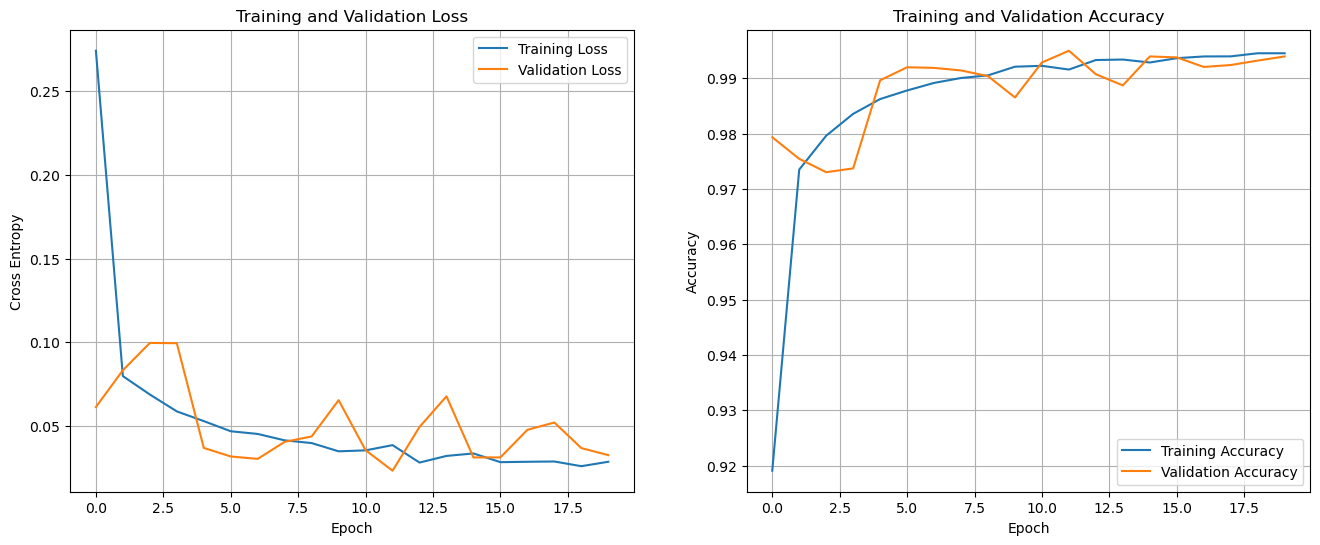

In [19]:
model.plot_history('fit')

In [20]:
model.fine_tune(data.train, data.validation, epochs=20, learning_rate=1e-5, log_dir=Path('logs/fine-tuning'))

Epoch 1/20
2175/2175 [==============================] - 33s 11ms/step - loss: 1.8824 - accuracy: 0.8638 - val_loss: 0.4469 - val_accuracy: 0.9494
Epoch 2/20
2175/2175 [==============================] - 30s 14ms/step - loss: 0.5832 - accuracy: 0.9381 - val_loss: 0.2044 - val_accuracy: 0.9719
Epoch 3/20
2175/2175 [==============================] - 32s 14ms/step - loss: 0.3297 - accuracy: 0.9588 - val_loss: 0.1155 - val_accuracy: 0.9825
Epoch 4/20
2175/2175 [==============================] - 37s 17ms/step - loss: 0.2039 - accuracy: 0.9709 - val_loss: 0.0752 - val_accuracy: 0.9866
Epoch 5/20
2175/2175 [==============================] - 52s 24ms/step - loss: 0.1322 - accuracy: 0.9784 - val_loss: 0.0539 - val_accuracy: 0.9905
Epoch 6/20
2175/2175 [==============================] - 48s 22ms/step - loss: 0.0918 - accuracy: 0.9837 - val_loss: 0.0433 - val_accuracy: 0.9919
Epoch 7/20
2175/2175 [==============================] - 60s 28ms/step - loss: 0.0657 - accuracy: 0.9874 - val_loss: 0.0337 -

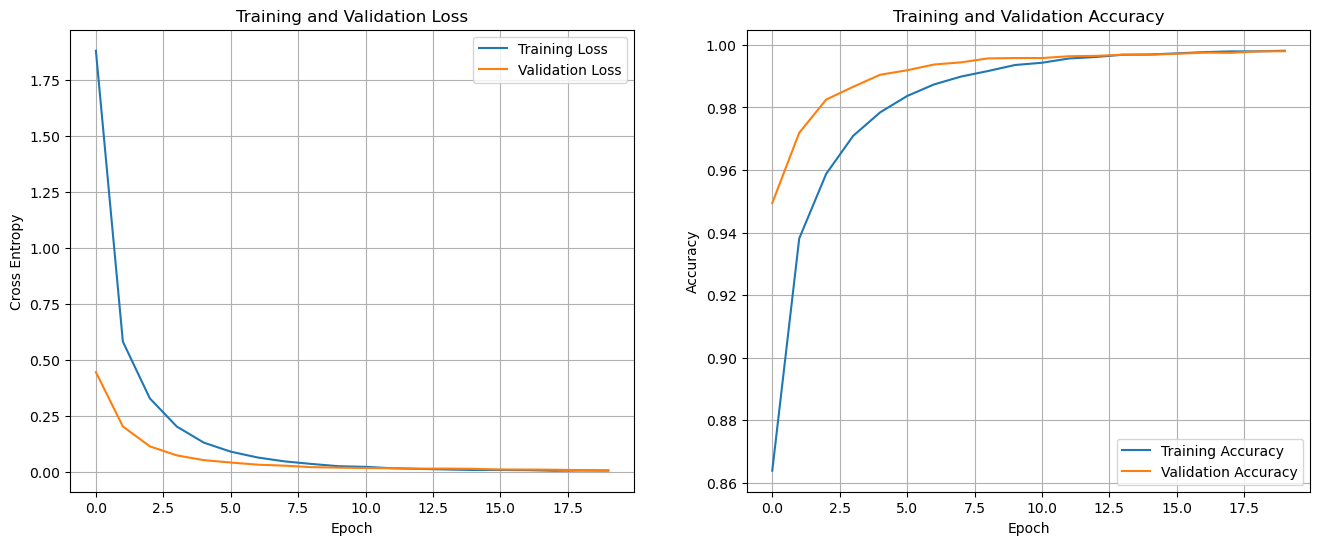

In [21]:
model.plot_history('fine_tuning')

In [22]:
model.save(Path('models/all-gestures'))

INFO:tensorflow:Assets written to: models/all-gestures/asl_mobilenet_tuned/assets


INFO:tensorflow:Assets written to: models/all-gestures/asl_mobilenet_tuned/assets


## Evaluation on the validation set

In [23]:
valid_evaluator = Evaluator(model.model, data.validation, data.class_labels)

100%|██████████| 544/544 [00:06<00:00, 80.60it/s]


In [24]:
valid_evaluator.evaluate()

Loss function: 0.073
Accuracy: 99.80%


In [25]:
valid_evaluator.confusion_matrix(size=800)

In [26]:
valid_evaluator.relative_errors(save_path='figures/all_errors.png')

## Quantization and evaluation

In [27]:
model.quantize(data.train, Path('models'))

INFO:tensorflow:Assets written to: temp/model/assets


INFO:tensorflow:Assets written to: temp/model/assets
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [28]:
interpreter = tf.lite.Interpreter(model_path='models/asl_mobilenet_quant.tflite')
quant_evaluator = Evaluator(interpreter, data.validation, data.class_labels, quantized=True)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
17400it [00:26, 652.24it/s]


In [29]:
quant_evaluator.evaluate()

Loss function: 0.460
Accuracy: 98.72%


In [30]:
quant_evaluator.confusion_matrix(size=800)

In [31]:
quant_evaluator.relative_errors()